In [1]:
from subpred.graph import (
    preprocess_data, get_substrate_matrix, create_heatmap, get_graph_plot
)

In [2]:
organism_names = ["athaliana"]  # "ecoli", "yeast", "human",

In [3]:
organism_name_to_id = {
    "ecoli":83333,
    "yeast":559292,
    "human":9606,
    "athaliana":3702
}
organism_ids={organism_name_to_id[organism_name] for organism_name in organism_names}
dataset_name="+".join(sorted(organism_names))

datasets_folder_path="data/datasets"
go_obo_path="data/raw/ontologies/go.obo"
chebi_obo_path="data/raw/ontologies/chebi.obo"
heatmap_output_path=f"plots/heatmap_{dataset_name}.png"
graph_output_path=f"plots/graph_{dataset_name}.png"
heatmap_title = f"Substrate molecular species overlaps for substrates with 20 or more transport proteins in dataset {dataset_name}"
graph_title = f"Relations between molecular species in for substrates with 20 or more transport proteins, only including abstractions\
      and tautomers, in dataset {dataset_name}"

Read datasets:

- Uniprot
- Uniprot GOA
- Ontologies
    - Chebi
    - GO

In [4]:
df_uniprot, df_uniprot_goa, graph_go, graph_chebi = preprocess_data(
    organism_ids=organism_ids,
    datasets_folder_path=datasets_folder_path,
    go_obo_path=go_obo_path,
    chebi_obo_path=chebi_obo_path,
    # TODO problem with this approach: Also removes terms that are connected to root node in other ways!
    # exclude_subtrees_rootnodes={"active transmembrane transporter activity"}  
)

43248
164519
60547


## Substrate matrix 

In [6]:
df_substrate_overlaps_full, dict_chebi_to_uniprot_full = get_substrate_matrix(
    datasets_folder_path=datasets_folder_path,
    graph_chebi=graph_chebi,
    graph_go=graph_go,
    df_uniprot_goa=df_uniprot_goa,
    min_overlap=20,
    max_overlap=1000000,
    include_ancestor_chebi_ids=True
)

1996
245
244


### Labels

In [27]:
import pandas as pd

chebi_id_to_name = {node: name for node, name in graph_chebi.nodes(data="name")}
df_chebi_to_uniprot = pd.DataFrame(
    dict_chebi_to_uniprot_full.items(), columns=["chebi_id", "Uniprot"]
)

df_chebi_to_uniprot["chebi_term"] = df_chebi_to_uniprot.chebi_id.map(chebi_id_to_name)

df_chebi_to_uniprot = df_chebi_to_uniprot.explode("Uniprot").reset_index(drop=True)

df_chebi_to_uniprot = df_chebi_to_uniprot[["Uniprot", "chebi_id", "chebi_term"]].sort_values(["Uniprot", "chebi_id"]).reset_index(drop=True)

In [31]:
df_chebi_to_uniprot[df_chebi_to_uniprot.chebi_term == "calcium(2+)"].Uniprot.unique().shape[0]

27

## Heatmap

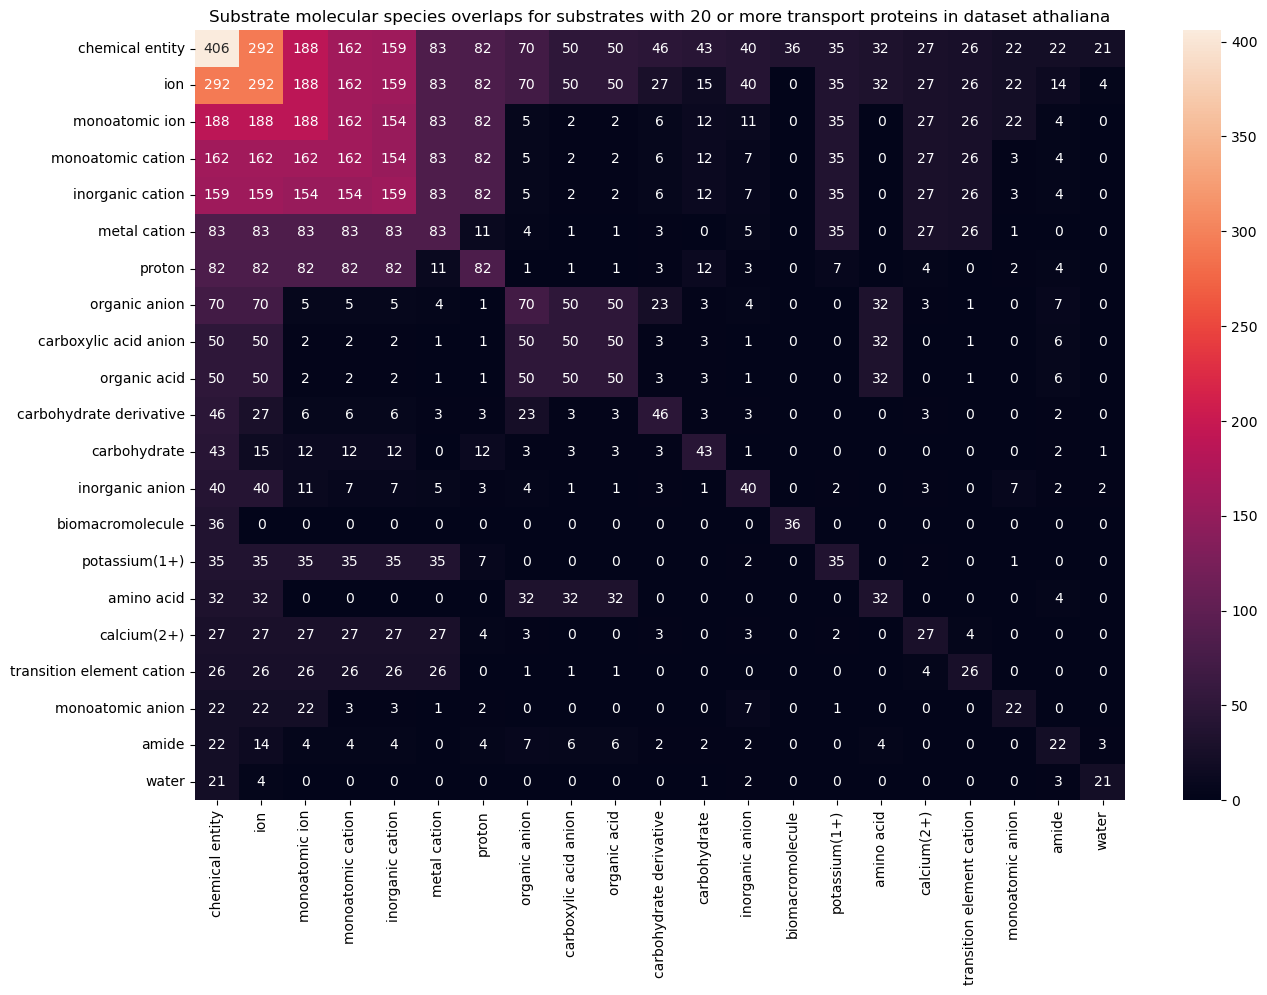

In [6]:
g = create_heatmap(
    df_matrix=df_substrate_overlaps_full,
    title=heatmap_title,
    width=15,
    height=10,
    lower_triangle_only=False,
    output_path=heatmap_output_path,
)
# from matplotlib import pyplot as plt
# g.figure.savefig("test.png",  bbox_inches='tight')

## Network

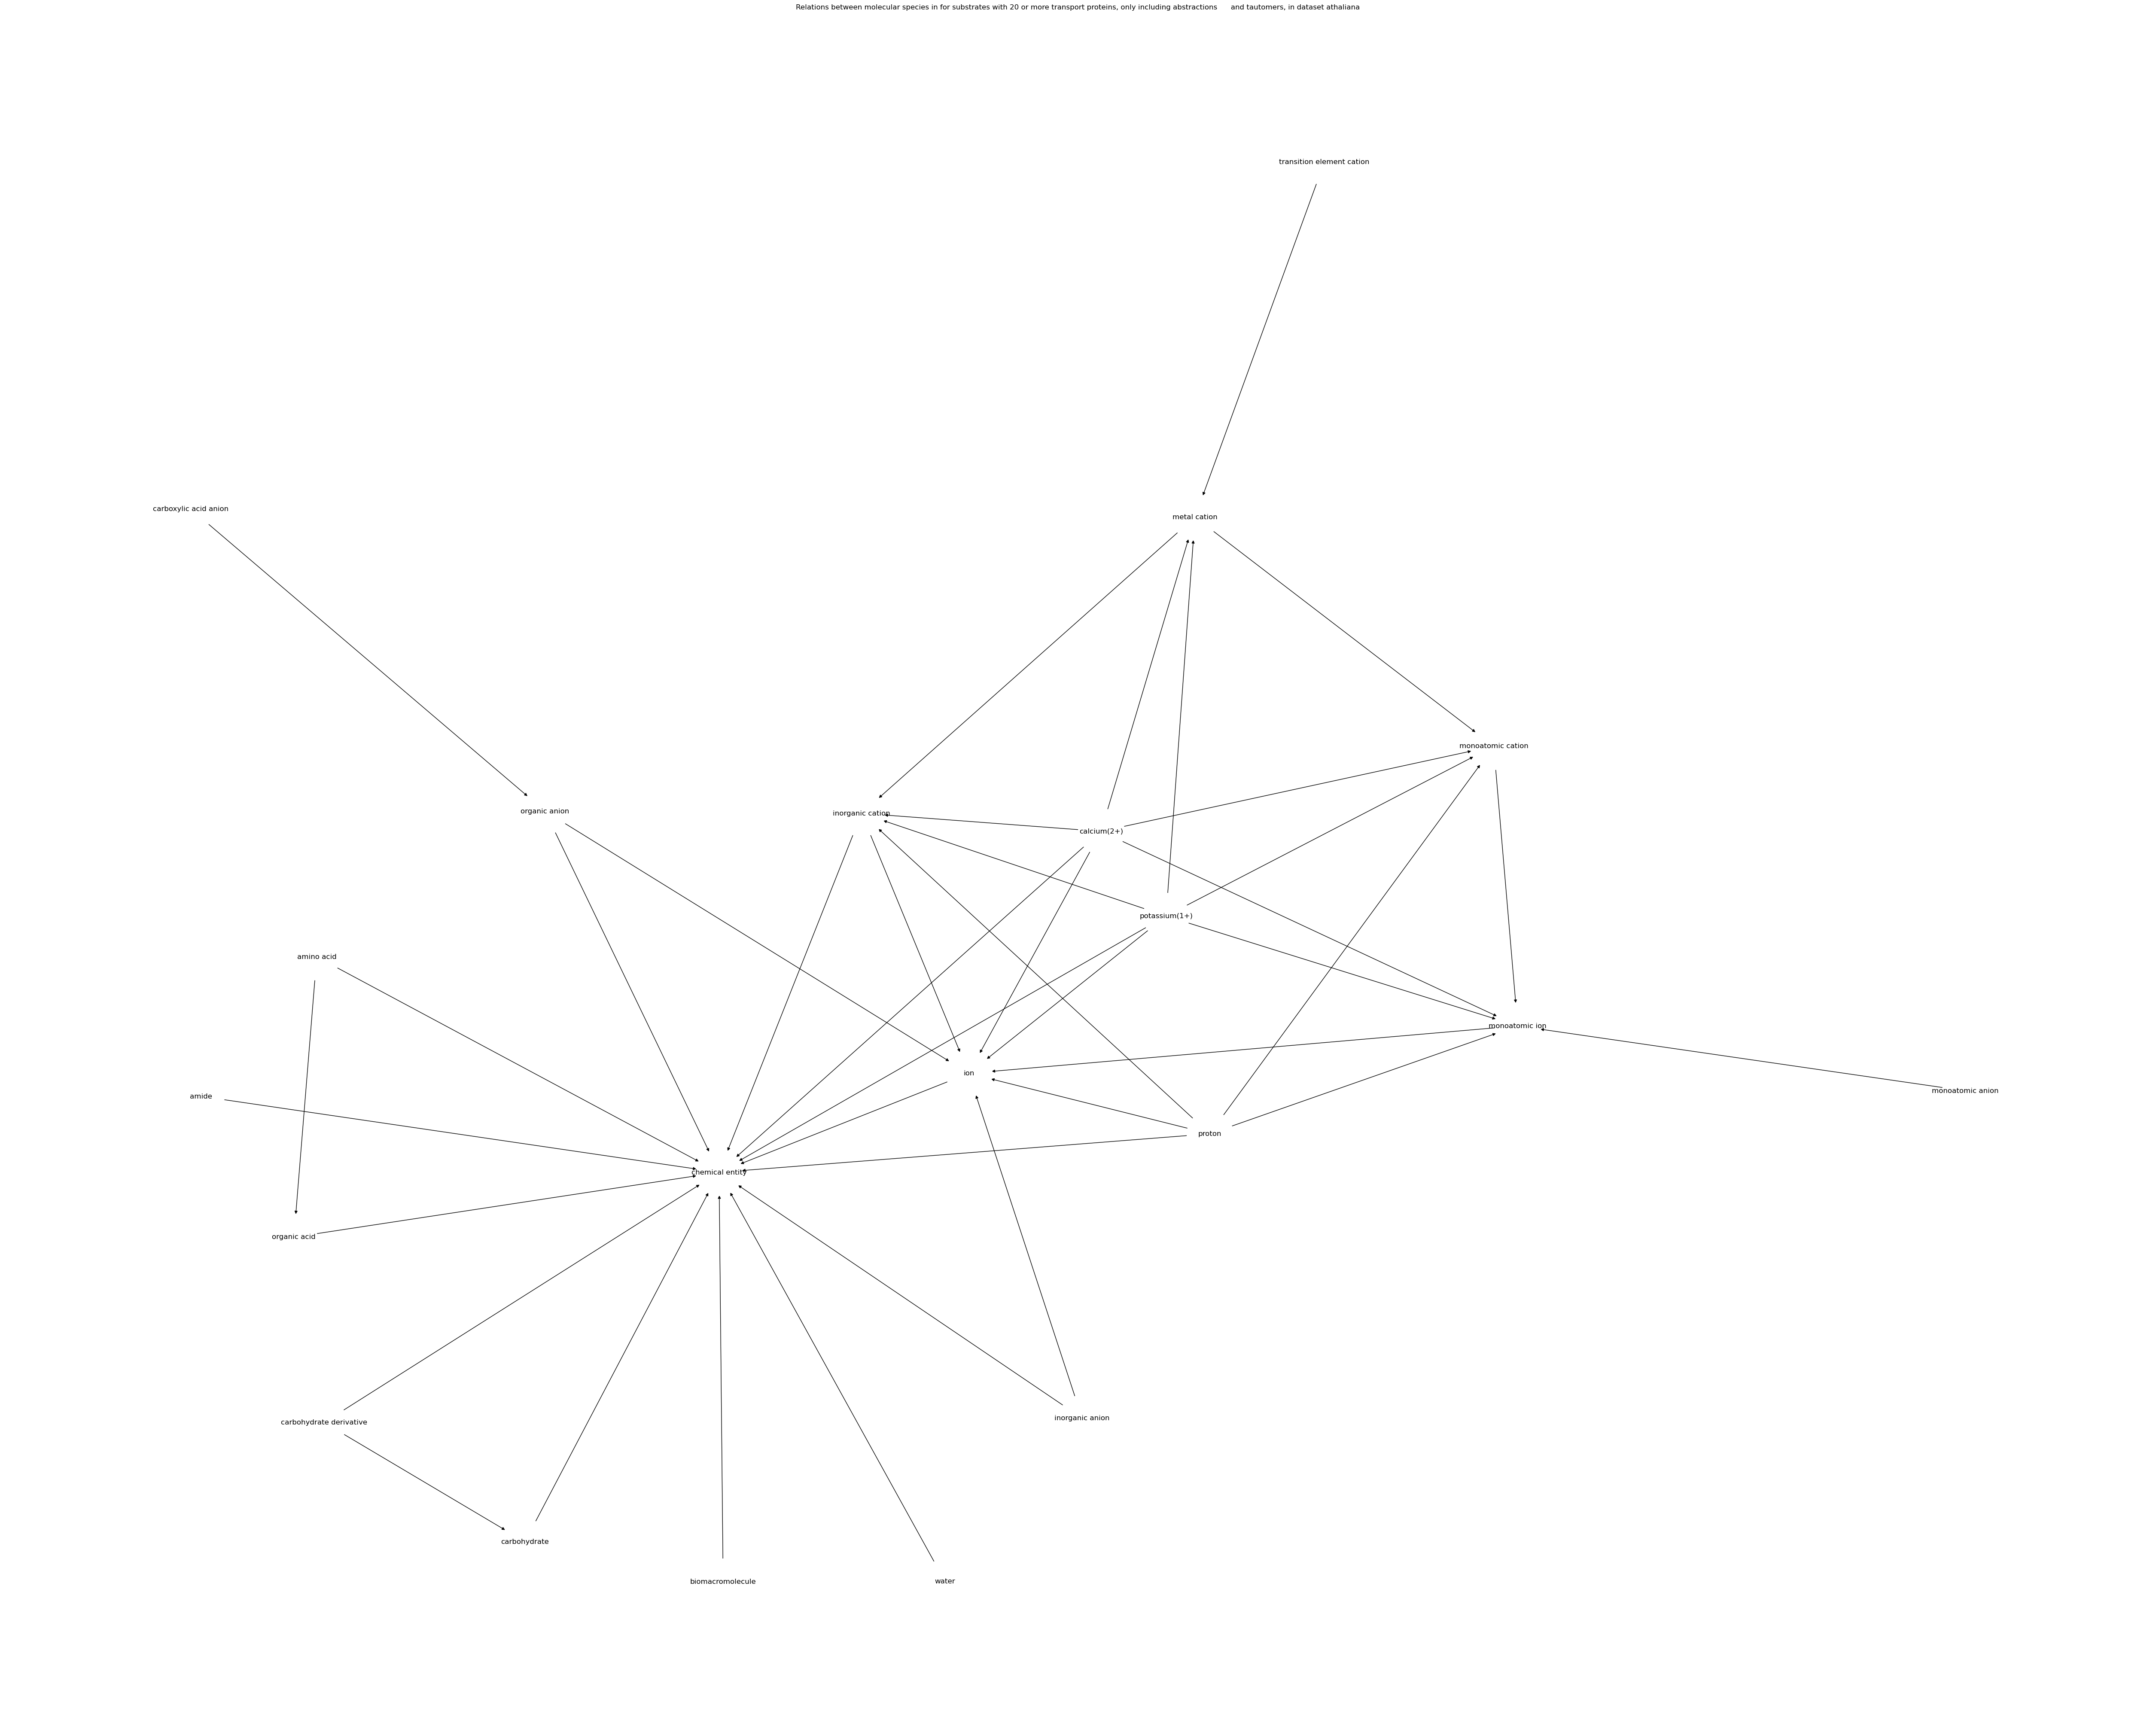

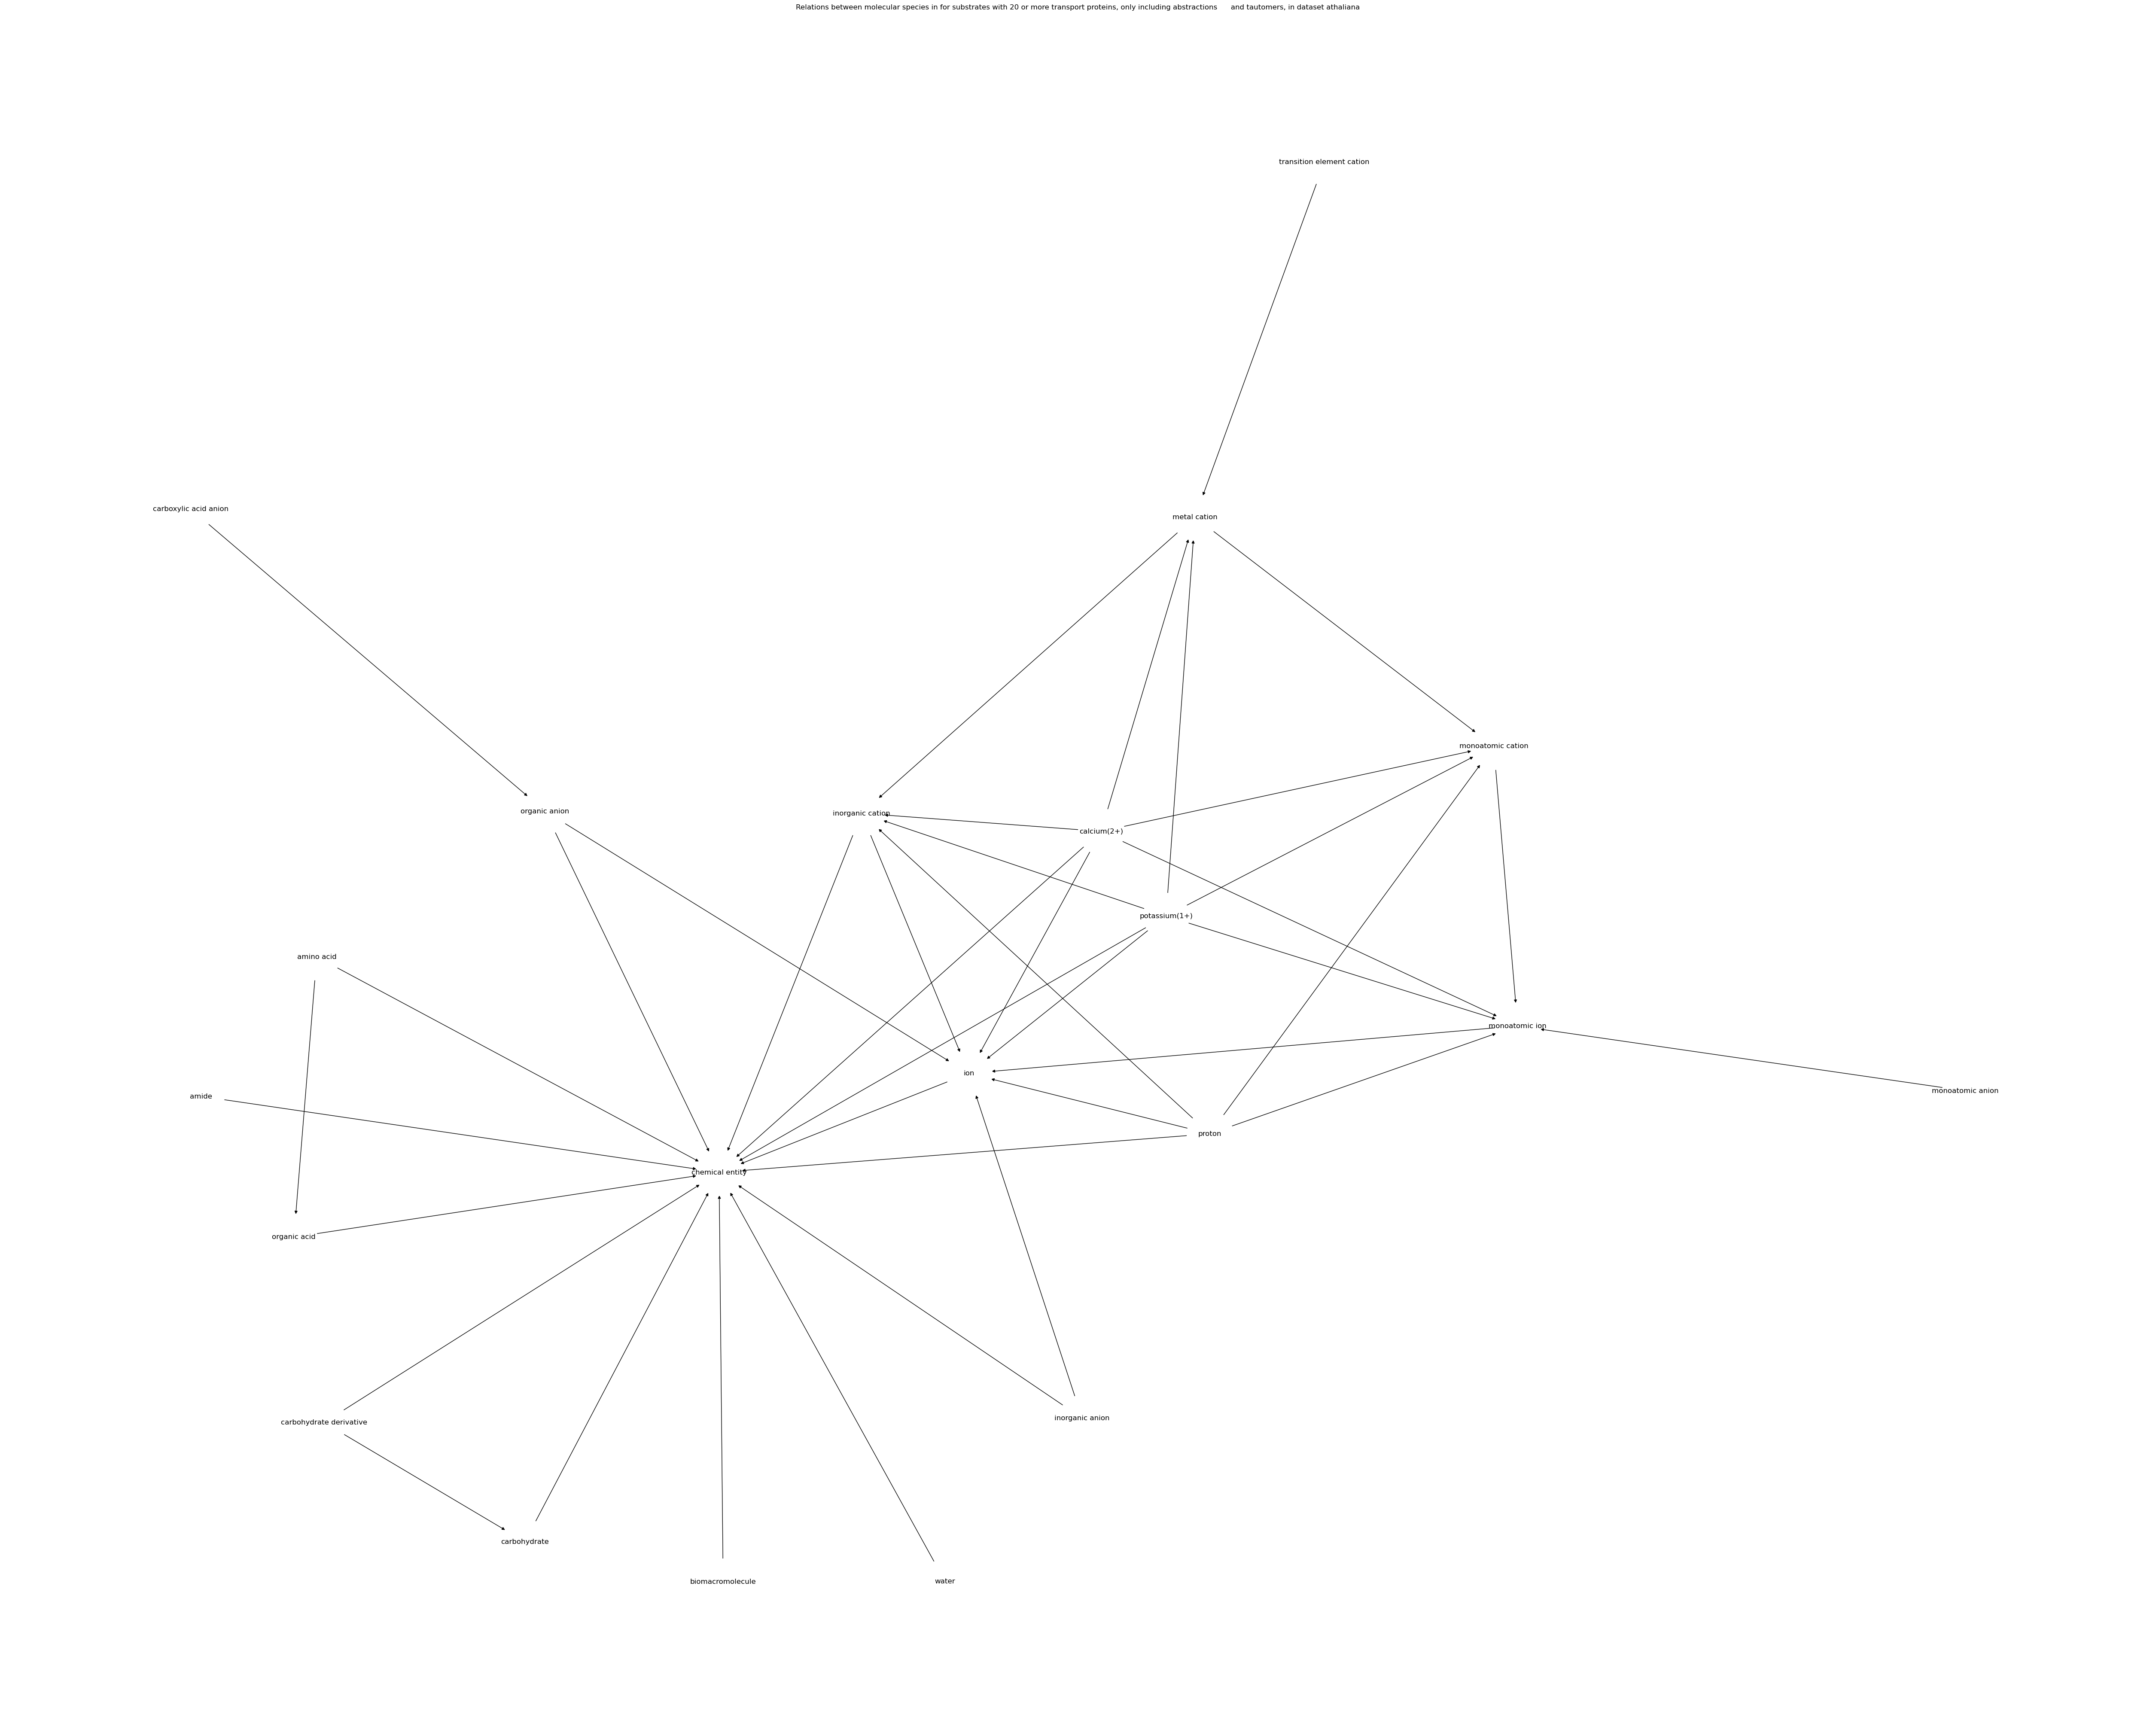

In [7]:
get_graph_plot(
    df_substrate_overlaps=df_substrate_overlaps_full,
    dict_chebi_to_uniprot=dict_chebi_to_uniprot_full,
    graph_chebi=graph_chebi,
    graph_output_path=graph_output_path,
    title=graph_title,
    node_size=6000,
    width=50,
    height=40,
    # relations_paths = {"is_a", "is_tautomer_of"}
)

## Questions

Why is chemical entity no longer part of graph? Where did it come from before?

In [8]:
from subpred.graph import get_go_chebi_mapping

df_go_to_chebi = get_go_chebi_mapping(
    datasets_folder_path=datasets_folder_path,
    graph_chebi=graph_chebi,
    graph_go=graph_go,
    include_ancestor_chebi_ids=True,
)

1996
245
244


In [9]:
df_go_to_chebi[df_go_to_chebi.chebi_term == "chemical entity"]

,go_id,chebi_id,chebi_term
3,GO:1905201,CHEBI:24431,chemical entity
8,GO:0042900,CHEBI:24431,chemical entity
11,GO:0042907,CHEBI:24431,chemical entity
17,GO:0015578,CHEBI:24431,chemical entity
20,GO:0015204,CHEBI:24431,chemical entity
...,...,...,...
973,GO:0005363,CHEBI:24431,chemical entity
976,GO:0005337,CHEBI:24431,chemical entity
980,GO:0055055,CHEBI:24431,chemical entity
990,GO:0005366,CHEBI:24431,chemical entity


In [10]:
df_go_to_chebi[df_go_to_chebi.go_id == "GO:0015204"]

,go_id,chebi_id,chebi_term
18,GO:0015204,CHEBI:16199,urea
19,GO:0015204,CHEBI:32988,amide
20,GO:0015204,CHEBI:24431,chemical entity


### Why are there overlaps between amino acid and ion?

Does it occur when not adding ancestors?

In [11]:
df_substrate_overlaps_noancestors, dict_chebi_to_uniprot_noancestors = get_substrate_matrix(
    datasets_folder_path=datasets_folder_path,
    graph_chebi=graph_chebi,
    graph_go=graph_go,
    df_uniprot_goa=df_uniprot_goa,
    min_overlap=20,
    max_overlap="half",
    include_ancestor_chebi_ids=False
)
df_substrate_overlaps_noancestors

1996
245
244


,monoatomic ion,monoatomic cation,inorganic cation,metal cation,proton,organic anion,carboxylic acid anion,organic acid,carbohydrate derivative,carbohydrate,...,biomacromolecule,potassium(1+),chemical entity,amino acid,calcium(2+),transition element cation,monoatomic anion,amide,water,ion
monoatomic ion,188,162,154,83,82,5,2,2,6,12,...,0,35,33,0,27,26,22,4,0,20
monoatomic cation,162,162,154,83,82,5,2,2,6,12,...,0,35,33,0,27,26,3,4,0,20
inorganic cation,154,154,159,83,82,5,2,2,6,12,...,0,35,32,0,27,26,3,4,0,19
metal cation,83,83,83,83,11,4,1,1,3,0,...,0,35,10,0,27,26,1,0,0,15
proton,82,82,82,11,82,1,1,1,3,12,...,0,7,29,0,4,0,2,4,0,4
organic anion,5,5,5,4,1,70,50,50,23,3,...,0,0,1,32,3,1,0,7,0,0
carboxylic acid anion,2,2,2,1,1,50,50,50,3,3,...,0,0,1,32,0,1,0,6,0,0
organic acid,2,2,2,1,1,50,50,50,3,3,...,0,0,1,32,0,1,0,6,0,0
carbohydrate derivative,6,6,6,3,3,23,3,3,46,3,...,0,0,3,0,3,0,0,2,0,0
carbohydrate,12,12,12,0,12,3,3,3,3,43,...,0,0,12,0,0,0,0,2,1,0


It doesn't happen when not adding ancestor chebi terms:

In [12]:
df_substrate_overlaps_noancestors[["amino acid", "ion"]].loc[["amino acid", "ion"]]

,amino acid,ion
amino acid,32,0
ion,0,20


In [13]:
df_substrate_overlaps_full[["amino acid", "ion"]].loc[["amino acid", "ion"]]

,amino acid,ion
amino acid,32,32
ion,32,292


### Why is there an overlap between amino acid and ion?

The reason was that the GO term **carboxylic acid transmembrane transporter activity** is defined as:

*Enables the transfer of carboxylic acids from one side of a membrane to the other. Carboxylic acids are organic acids containing one or more carboxyl (COOH) groups or anions (COO-).*

Amino acids are considered anions when they occur in basic conditions, and cations when occurring in acidic conditions. In solution, amino acids occur as zwitterions. 



Additionally, we found that the GO term that is annotated with "Ion" is not "Ion transmembrane transporter activity", but "P-type transmembrane transporter activity", which is a form of active transport that uses the ATP-ADP reaction. This term describes the mechanism, which is active transport, not a *substrate* transport. In fact, a go term called *ion transmembrane transporter activity* does not exist, only monoatomic ion and cation or anion.

One idea to solve this problem would be to exclude active and passive transport descendants from the list of relevant GO terms.




In [14]:
# Is ion still in go chebi mapping?

In [15]:
df_che

NameError: name 'df_che' is not defined

In [ ]:
excluded_nodes_active = {'GO:0086057', 'GO:2001259', 'GO:0086008', 'GO:1905058', 'GO:1905030', 'GO:0022842', 'GO:0022829', 'GO:0032237', 'GO:0099109', 'GO:0043854', 'GO:1905273', 'GO:0097365', 'GO:2000969', 'GO:0015276', 'GO:2000310', 'GO:0086058', 'GO:0015252', 'GO:0015473', 'GO:0004970', 'GO:1902428', 'GO:0061778', 'GO:0086075', 'GO:1902282', 'GO:0140232', 'GO:1902606', 'GO:0016286', 'GO:0022852', 'GO:0005247', 'GO:1902942', 'GO:0099635', 'GO:0086063', 'GO:1900129', 'GO:0022843', 'GO:0022841', 'GO:1905152', 'GO:0097682', 'GO:0086041', 'GO:0140227', 'GO:1901842', 'GO:0004972', 'GO:1902514', 'GO:0036082', 'GO:0086087', 'GO:1901385', 'GO:0005237', 'GO:1901529', 'GO:0072346', 'GO:0005253', 'GO:1903760', 'GO:0106427', 'GO:0022839', 'GO:1903609', 'GO:0005250', 'GO:0008332', 'GO:0086020', 'GO:0031585', 'GO:1905054', 'GO:0015471', 'GO:0099099', 'GO:0055077', 'GO:0086061', 'GO:0015400', 'GO:0099101', 'GO:0008519', 'GO:1902941', 'GO:0072345', 'GO:0015269', 'GO:0060072', 'GO:0016934', 'GO:1901980', 'GO:0022894', 'GO:0005272', 'GO:0099508', 'GO:0140417', 'GO:0015474', 'GO:0005251', 'GO:1990806', 'GO:1902943', 'GO:1902259', 'GO:0005216', 'GO:0005243', 'GO:0099094', 'GO:0035235', 'GO:2001257', 'GO:1903953', 'GO:1903952', 'GO:0086060', 'GO:0070089', 'GO:1903049', 'GO:0016933', 'GO:1903763', 'GO:1905271', 'GO:1901386', 'GO:0061907', 'GO:0022859', 'GO:0099511', 'GO:0060315', 'GO:0106428', 'GO:0015398', 'GO:1902261', 'GO:2000311', 'GO:0160039', 'GO:0048763', 'GO:0044736', 'GO:1902607', 'GO:0098991', 'GO:1902939', 'GO:0098697', 'GO:1901339', 'GO:0015475', 'GO:0140070', 'GO:0022834', 'GO:1903762', 'GO:1904315', 'GO:1905057', 'GO:0015274', 'GO:0010361', 'GO:0035381', 'GO:1902608', 'GO:0005231', 'GO:0099108', 'GO:2001258', 'GO:1903954', 'GO:1902161', 'GO:1904878', 'GO:1904879', 'GO:0062054', 'GO:0046933', 'GO:0072320', 'GO:0086056', 'GO:1902938', 'GO:0005225', 'GO:1904295', 'GO:0022849', 'GO:0005249', 'GO:0015481', 'GO:0140135', 'GO:0005248', 'GO:1990760', 'GO:0086095', 'GO:0101013', 'GO:0015264', 'GO:0015272', 'GO:0015280', 'GO:1901841', 'GO:0008381', 'GO:0005261', 'GO:0015288', 'GO:0099507', 'GO:0086006', 'GO:0000269', 'GO:0015271', 'GO:0099626', 'GO:0099604', 'GO:0005217', 'GO:0005260', 'GO:0061577', 'GO:0022850', 'GO:1901341', 'GO:0005267', 'GO:0015467', 'GO:0036081', 'GO:0005230', 'GO:1901587', 'GO:0086007', 'GO:0098695', 'GO:0005219', 'GO:0022851', 'GO:0022828', 'GO:1902427', 'GO:1905151', 'GO:0140233', 'GO:0010362', 'GO:0022824', 'GO:0097603', 'GO:1903048', 'GO:0086078', 'GO:0008331', 'GO:1904783', 'GO:0015279', 'GO:1904296', 'GO:0004971', 'GO:0010359', 'GO:0005244', 'GO:0086088', 'GO:0008068', 'GO:1901585', 'GO:0022831', 'GO:1905272', 'GO:0015476', 'GO:0090676', 'GO:1904297', 'GO:1904782', 'GO:0097604', 'GO:0005222', 'GO:0015483', 'GO:0060316', 'GO:0045831', 'GO:0022840', 'GO:0090686', 'GO:0010461', 'GO:0005228', 'GO:0008308', 'GO:0004931', 'GO:0098990', 'GO:1903817', 'GO:1905150', 'GO:0010360', 'GO:0005234', 'GO:0099105', 'GO:0005252', 'GO:0015267', 'GO:0022803', 'GO:1902429', 'GO:1903761', 'GO:1901843', 'GO:0019182', 'GO:0010462', 'GO:1990028', 'GO:0015478', 'GO:0015278', 'GO:1901340', 'GO:0086086', 'GO:1900128', 'GO:0015250', 'GO:0061797', 'GO:1901979', 'GO:0086062', 'GO:0008086', 'GO:0098782', 'GO:1901586', 'GO:0086089', 'GO:0106426', 'GO:0015254', 'GO:0099095', 'GO:1902433', 'GO:0005245', 'GO:0031587', 'GO:0086059', 'GO:0060314', 'GO:0086079', 'GO:0015255', 'GO:0005221', 'GO:0022832', 'GO:0022835', 'GO:1901387', 'GO:0005227', 'GO:0015265', 'GO:0005254', 'GO:0005262', 'GO:0022836', 'GO:0086077', 'GO:2000312', 'GO:0005220', 'GO:0005242', 'GO:0099142', 'GO:0030171', 'GO:0015275', 'GO:0015277', 'GO:1902940', 'GO:0099100', 'GO:0016061', 'GO:1902159', 'GO:0062156', 'GO:0099102', 'GO:0031586', 'GO:0086076', 'GO:0098989', 'GO:1903818', 'GO:0086090', 'GO:0045832', 'GO:0097364', 'GO:0005229', 'GO:0043855', 'GO:0022848', 'GO:0005223', 'GO:1902160', 'GO:0022886', 'GO:1902260'}

In [ ]:
len(excluded_nodes_active)

279